In [ ]:
# Install libraries.
!pip install biopython==1.81
!pip install tensorflow==2.12.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.3 MB/s eta 0:00:00
  Attempti

In [ ]:
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import time

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Number of train sequences: 16076
Number of validation sequences: 4020
Number of test sequences: 8612
Epoch 1/10
503/503 [==============================] - 931s 2s/step - loss: 0.4862 - accuracy: 0.8012 - val_loss: 0.3645 - val_accuracy: 0.8386
Epoch 2/10
503/503 [==============================] - 903s 2s/step - loss: 0.3516 - accuracy: 0.8431 - val_loss: 0.3145 - val_accuracy: 0.8614
Epoch 3/10
503/503 [==============================] - 884s 2s/step - loss: 0.3109 - accuracy: 0.8630 - val_loss: 0.2954 - val_accuracy: 0.8726
Epoch 4/10
503/503 [==============================] - 876s 2s/step - loss: 0.2867 - accuracy: 0.8729 - val_loss: 0.3203 - val_accuracy: 0.8706
Epoch 5/10
503/503 [==============================] - 872s 2s/step - loss: 0.2756 - accuracy: 0.8786 - val_loss: 0.2696 - val_accuracy: 0.8858
Epoch 6/10
503/503 [==============================] - 871s 2s/step - loss: 0.2699 - accuracy: 0.8799 - val_loss: 0.3689 - val_accuracy: 0.8552
Epoch 7/10
503/503 [=====================

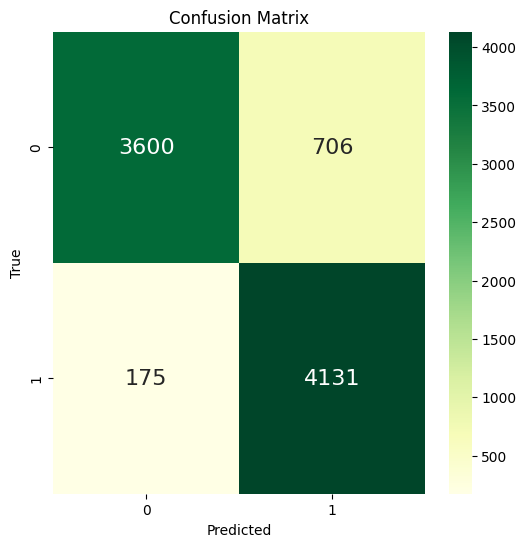

In [ ]:
import numpy as np
from Bio import SeqIO

def load_fasta(file_path, label):
    """Loads a FASTA file and returns sequences and their associated label."""
    sequences = []
    labels = []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
        labels.append(label)
    return sequences, labels

# Load training data
train_positive_file = "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/train_positive.fasta"  # Replace with actual path
train_negative_file = "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/train_neg.fasta"
train_positive_sequences, train_positive_labels = load_fasta(train_positive_file, 1)
train_negative_sequences, train_negative_labels = load_fasta(train_negative_file, 0)

# Load test data (separate test set)
test_positive_file = "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/test_positive.fasta"
test_negative_file = "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/test_neg.fasta"
test_positive_sequences, test_positive_labels = load_fasta(test_positive_file, 1)
test_negative_sequences, test_negative_labels = load_fasta(test_negative_file, 0)

# Combine training sequences and labels
train_all_sequences = train_positive_sequences + train_negative_sequences
train_all_labels = train_positive_labels + train_negative_labels

test_all_sequences = test_positive_sequences + test_negative_sequences
test_all_labels = test_positive_labels + test_negative_labels

# Convert labels to NumPy arrays
train_all_labels = np.array(train_all_labels)
test_all_labels = np.array(test_all_labels)

def one_hot_encode(sequence):
    """One-hot encodes a protein sequence."""
    amino_acids = "ARNDCQEGHILKMFPSTWYV"
    mapping = {aa: i for i, aa in enumerate(amino_acids)}
    encoded_sequence = np.zeros((len(sequence), len(amino_acids)))
    for i, aa in enumerate(sequence):
        if aa in mapping:
            encoded_sequence[i, mapping[aa]] = 1
    return encoded_sequence

def pad_sequences(sequences, max_len):
    """Pads sequences to a fixed length."""
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            padded_sequences.append(seq[:max_len])
        else:
            padded_sequences.append(seq + "X" * (max_len - len(seq)))
    return padded_sequences

max_len = 100  # Adjust as needed

# Process training data
train_padded_sequences = pad_sequences(train_all_sequences, max_len)
train_encoded_sequences = np.array([one_hot_encode(seq) for seq in train_padded_sequences])

# Process test data
test_padded_sequences = pad_sequences(test_all_sequences, max_len)
test_encoded_sequences = np.array([one_hot_encode(seq) for seq in test_padded_sequences])

# Split training into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_encoded_sequences, train_all_labels, test_size=0.2, random_state=42)

# Test set remains separate
X_test, y_test = test_encoded_sequences, test_all_labels

# Print dataset statistics
print(f"Number of train sequences: {len(X_train)}")
print(f"Number of validation sequences: {len(X_val)}")
print(f"Number of test sequences: {len(X_test)}")

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """Implements a transformer encoder block."""
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    """Builds the complete transformer model."""
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model(inputs, outputs)

# Model parameters
input_shape = (max_len, 20)
head_size = 256
num_heads = 4
ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128]
dropout = 0.4
mlp_dropout = 0.4

model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
start_time = time.time()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
training_time = time.time() - start_time

# Evaluate on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Execution Time: {training_time:.2f} seconds")
print("Confusion Matrix:")
print(conf_matrix)
print("Confusion Matrix:")
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




In [ ]:
import numpy as np
import tensorflow as tf
import time
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    cohen_kappa_score, matthews_corrcoef, confusion_matrix
)

# Load FASTA sequences
def load_fasta(file_path, label):
    sequences, labels = [], []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
        labels.append(label)
    return sequences, labels

# Load datasets
train_pos_file, train_neg_file = "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/train_positive.fasta", "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/train_neg.fasta"
test_pos_file, test_neg_file = "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/test_positive.fasta", "/content/drive/MyDrive/Research/Anti-Viral_Peptides/Version 3.0 (Review Work)/test_neg.fasta"

train_pos_seq, train_pos_labels = load_fasta(train_pos_file, 1)
train_neg_seq, train_neg_labels = load_fasta(train_neg_file, 0)
test_pos_seq, test_pos_labels = load_fasta(test_pos_file, 1)
test_neg_seq, test_neg_labels = load_fasta(test_neg_file, 0)

# Combine data
train_sequences = train_pos_seq + train_neg_seq
train_labels = np.array(train_pos_labels + train_neg_labels)
test_sequences = test_pos_seq + test_neg_seq
test_labels = np.array(test_pos_labels + test_neg_labels)

# One-hot encoding function
def one_hot_encode(sequence):
    amino_acids = "ARNDCQEGHILKMFPSTWYV"
    mapping = {aa: i for i, aa in enumerate(amino_acids)}
    encoded_seq = np.zeros((len(sequence), len(amino_acids)))
    for i, aa in enumerate(sequence):
        if aa in mapping:
            encoded_seq[i, mapping[aa]] = 1
    return encoded_seq

# Pad sequences
def pad_sequences(sequences, max_len):
    return [seq[:max_len] + "X" * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

max_len = 100  # Adjust based on dataset

# Process sequences
train_padded = pad_sequences(train_sequences, max_len)
train_encoded = np.array([one_hot_encode(seq) for seq in train_padded])
test_padded = pad_sequences(test_sequences, max_len)
test_encoded = np.array([one_hot_encode(seq) for seq in test_padded])

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(train_encoded, train_labels, test_size=0.2, random_state=42)
X_test, y_test = test_encoded, test_labels

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(res)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Transformer Model
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_blocks, mlp_units, dropout=0.3, mlp_dropout=0.3):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)

    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

# Model parameters
input_shape = (max_len, 20)
model = build_transformer_model(
    input_shape, head_size=512, num_heads=6, ff_dim=16, num_blocks=6,
    mlp_units=[256, 128], dropout=0.3, mlp_dropout=0.3
)

# Optimizer & Learning Rate Scheduler
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Focal Loss for handling class imbalance
# Focal Loss for handling class imbalance
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_t * tf.pow((1 - p_t), gamma) * bce
    return loss


# Compile Model
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=["accuracy"])

# Class Weights to handle imbalance
class_weights = {0: 1.5, 1: 1.0}

# Train Model
start_time = time.time()
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=20, batch_size=32, class_weight=class_weights,
    callbacks=[lr_scheduler, early_stopping]
)
training_time = time.time() - start_time

# Evaluate Model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Execution Time: {training_time:.2f} seconds")
print("Confusion Matrix:")

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGn', annot_kws={"size": 16})
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Epoch 1/20
503/503 [==============================] - 4643s 9s/step - loss: 3.2178 - accuracy: 0.7549 - val_loss: 2.3347 - val_accuracy: 0.7266 - lr: 1.0000e-04
Epoch 2/20
 48/503 [=>............................] - ETA: 1:03:50 - loss: 2.2718 - accuracy: 0.7917

1️⃣BiLSTM with Attention
2️⃣ CNN-BiLSTM Hybrid Model
3️⃣ Graph Neural Network (GNN) for Peptide Classification

In [ ]:
import numpy as np
import tensorflow as tf
import time
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, matthews_corrcoef, confusion_matrix

# Load FASTA sequences
def load_fasta(file_path, label):
    sequences, labels = [], []
    for record in SeqIO.parse(file_path, "fasta"):
        sequences.append(str(record.seq))
        labels.append(label)
    return sequences, labels

# One-hot encoding function
def one_hot_encode(sequence, max_len=100):
    amino_acids = "ARNDCQEGHILKMFPSTWYV"
    mapping = {aa: i for i, aa in enumerate(amino_acids)}
    encoded_sequence = np.zeros((max_len, len(amino_acids)))
    for i, aa in enumerate(sequence[:max_len]):
        if aa in mapping:
            encoded_sequence[i, mapping[aa]] = 1
    return encoded_sequence

# Load datasets
train_pos, train_neg = load_fasta("train_positive.fasta", 1), load_fasta("train_neg.fasta", 0)
test_pos, test_neg = load_fasta("test_positive.fasta", 1), load_fasta("test_neg.fasta", 0)

# Combine data
train_sequences, train_labels = train_pos[0] + train_neg[0], train_pos[1] + train_neg[1]
test_sequences, test_labels = test_pos[0] + test_neg[0], test_pos[1] + test_neg[1]

# Encode sequences
max_len = 100
X_train = np.array([one_hot_encode(seq, max_len) for seq in train_sequences])
X_test = np.array([one_hot_encode(seq, max_len) for seq in test_sequences])
y_train, y_test = np.array(train_labels), np.array(test_labels)

# Split training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Model 1: BiLSTM with Attention ###
def build_bilstm_attention(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(inputs)
    attention = tf.keras.layers.Attention()([x, x])
    x = tf.keras.layers.GlobalAveragePooling1D()(attention)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

### Model 2: CNN-BiLSTM Hybrid ###
def build_cnn_bilstm(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inputs, outputs)

# Select model
target_model = "BiLSTM_Attention"  # Change to "CNN_BiLSTM" as needed
if target_model == "BiLSTM_Attention":
    model = build_bilstm_attention((max_len, 20))
elif target_model == "CNN_BiLSTM":
    model = build_cnn_bilstm((max_len, 20))

# Compile and train
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
start_time = time.time()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
training_time = time.time() - start_time

# Evaluate model
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Execution Time: {training_time:.2f} seconds")
print("Confusion Matrix:")
print(conf_matrix)
